# Import

In [1]:
import torch
import os
from matplotlib import pyplot as plt
import numpy as np

from PIL import Image

from fitting.FittingConfiguration import FittingConfiguration
from utils.image_helpers import plot_image_grid, get_images
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration
from simulation.SimulationPipeline import SimulationPipeline
from utils.evaluation_helpers import performance_from_images, average_performances

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Load Image and Add Artifacts

In [2]:
image_path = 'data/raw_images/sample_images/canonical_mri.png'
k_factor = 0.6
snr = 64
pf_factor = 1.0
image_size = (100,100)

(100, 100, 1)


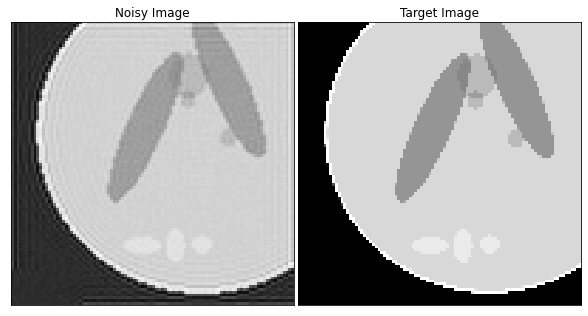

In [3]:
target_image = np.array(Image.open(image_path).convert('L').resize(image_size))[:,:,None]
target_image = target_image.astype(np.float32)/255
image_dimensions = target_image.shape
print(image_dimensions)

pipeline = SimulationPipeline(k_factor, snr, pf_factor)
noisy_image = pipeline.simulate(target_image)

plot_image_grid([noisy_image, target_image], ['Noisy Image', 'Target Image'])
plt.show()

# Configuration

In [4]:
fit_model_configuration = FittingConfiguration()

fit_model_configuration.model_type = 'deep'
fit_model_configuration.input_shape = [10, 10]
fit_model_configuration.number_of_hidden_channels = 32
fit_model_configuration.number_of_layers = 4

fit_model_configuration.log_frequency = 100
fit_model_configuration.convergence_check_length = None
fit_model_configuration.number_of_iterations = 20000

fit_model_configuration.result_path = None
fit_model_configuration.image_dimensions = image_dimensions
fit_model_configuration.save_losses = False
fit_model_configuration.find_best = False
fit_model_configuration.constant_input = True

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(str(fit_model_configuration))

image_dimensions: (100, 100, 1)  
result_path: None  
model_type: deep  
input_shape: [10, 10]  
number_of_layers: 4  
number_of_hidden_channels: 32  
number_of_iterations: 20000  
number_of_runs: 10  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: False  
save_losses: False  
constant_input: True  
data_type: <class 'torch.cuda.FloatTensor'>  



# Fitting

In [5]:
number_of_models = 30
number_of_intervals = 200
size_of_interval = int(fit_model_configuration.number_of_iterations/number_of_intervals)
fit_model_configuration.number_of_iterations = size_of_interval

In [6]:
numbers_of_results = range(1,number_of_models)

In [7]:
models = []
fitters = []
for _ in range(number_of_models):
    models.append(create_model_from_configuration(fit_model_configuration))
    fitters.append(create_fitter_from_configuration(fit_model_configuration))

In [8]:
model_step_images = []
for interval_index in range(number_of_intervals):
    step_images = []
    for model_index, (model, fitter) in enumerate(zip(models, fitters)):
        log_prefix = f'{interval_index + 1}/{number_of_intervals}, {model_index + 1}/{number_of_models}; '
        fitter(model, noisy_image, target_image, log_prefix=log_prefix)
        step_images.append(fitter.get_best_image())
    model_step_images.append(step_images)

# Combining Images & Calculating Performances

In [9]:
def generate_plot_vectors(perfs, y_key, x_key, size_of_interval=None):
    x_vec = [x['id'][x_key] for x in perfs]
    if size_of_interval is not None:
        x_vec = [x * size_of_interval for x in x_vec]
    y_vec = [y[y_key] for y in perfs]
    return x_vec, y_vec

In [10]:
def average_images(image_list):
    return np.mean(np.array(image_list), axis=0)

def median_images(image_list):
    return np.median(np.array(image_list), axis=0)

functions = {'Median Image': median_images, 'Average Image': average_images}

for function in functions:
    print(function)

Median Image
Average Image


In [11]:
combined_performances = []
for step_index, step_images in enumerate(model_step_images):
    print(f'{step_index+1}/{len(model_step_images)}', end='\r')
    for number_of_models in range(len(step_images)):
        for function in functions:
            perf_id = {'number of models': number_of_models, 'function': functions[function], 'step': step_index} 
            avg_image = functions[function](step_images[:number_of_models+1])
            performance_noisy = performance_from_images(avg_image, noisy_image, {'type': 'noisy', **perf_id})
            performance_target = performance_from_images(avg_image, target_image, {'type': 'target', **perf_id})
            combined_performances.append(performance_noisy)
            combined_performances.append(performance_target)
measures = [key for key in combined_performances[0].keys() if key != 'id']
print(measures)

noisy_baseline = performance_from_images(noisy_image, target_image, {'type': 'baseline'})

['mse', 'psnr', 'vif', 'ssim']


# Compare Performance wrt noisy & target

In [12]:
performances = [x for x in combined_performances if (x['id']['number of models'] == number_of_models and x['id']['function'] == average_images)]

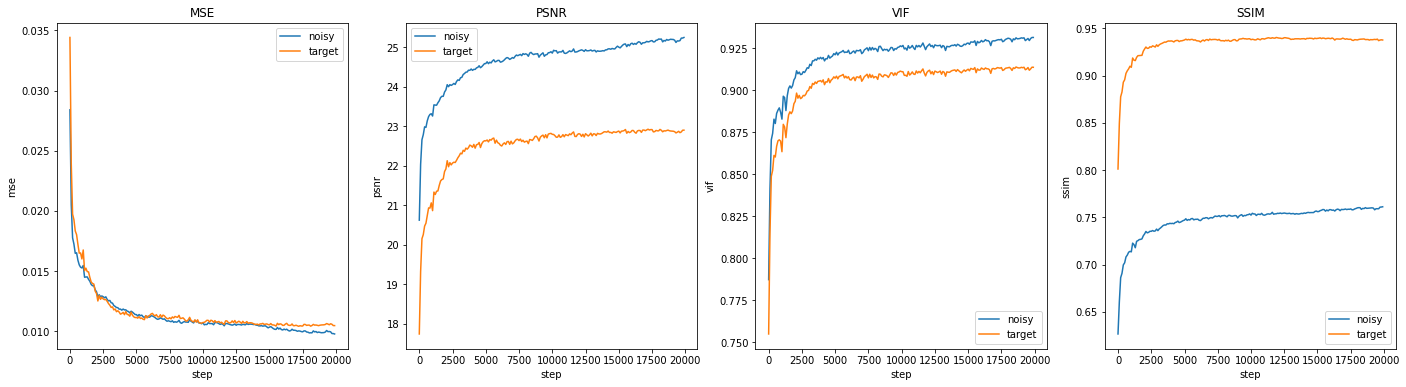

In [13]:
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))
for axis, measure in zip(axes, measures):
    for performance_type in ['noisy', 'target']:
        filtered_performances = [x for x in performances if x['id']['type'] == performance_type]
        x_vec, y_vec = generate_plot_vectors(filtered_performances, measure, 'step', size_of_interval)
        axis.plot(x_vec, y_vec, label=performance_type)
    axis.set_xlabel('step')
    axis.set_ylabel(measure)
    axis.legend()
    axis.set_title(measure.upper())

# Compare Combination Functions

In [14]:
performances = [x for x in combined_performances if (x['id']['number of models'] == number_of_models and x['id']['type'] == 'target')]

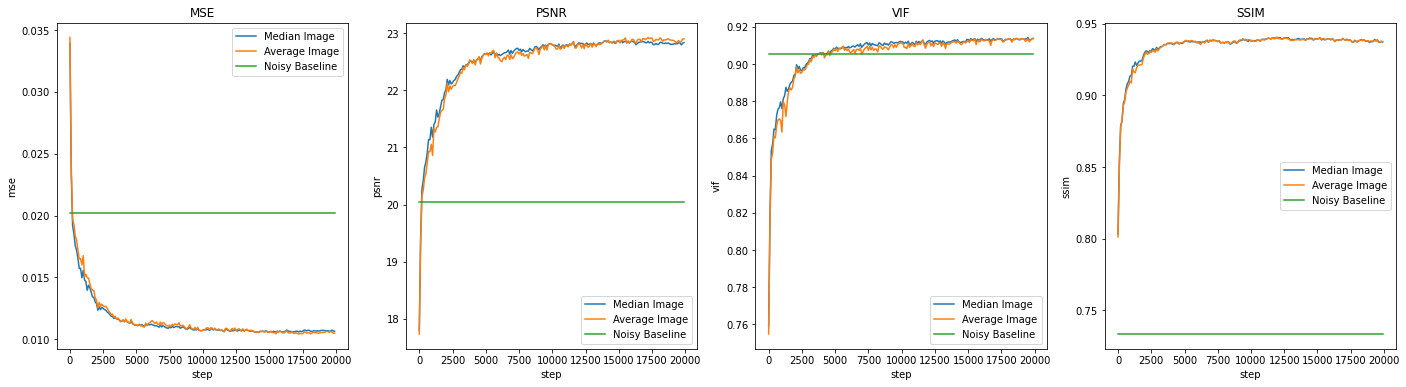

In [15]:
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))
for axis, measure in zip(axes, measures):
    for function in functions:
        filtered_performances = [x for x in performances if x['id']['function'] == functions[function]]
        x_vec, y_vec = generate_plot_vectors(filtered_performances, measure, 'step', size_of_interval)
        axis.plot(x_vec, y_vec, label=function)
    axis.plot(x_vec, [noisy_baseline[measure]]*len(y_vec), label='Noisy Baseline')
    axis.set_xlabel('step')
    axis.set_ylabel(measure)
    axis.legend()
    axis.set_title(measure.upper())

# Effect of Combining Images

In [16]:
performances = [x for x in combined_performances if (x['id']['function'] == median_images and x['id']['type'] == 'target' and x['id']['step'] == number_of_intervals-1)]
keys_to_average_over = [k for k in performances[0]['id'] if k != 'number of models']
performances = average_performances(performances, keys_to_average_over)

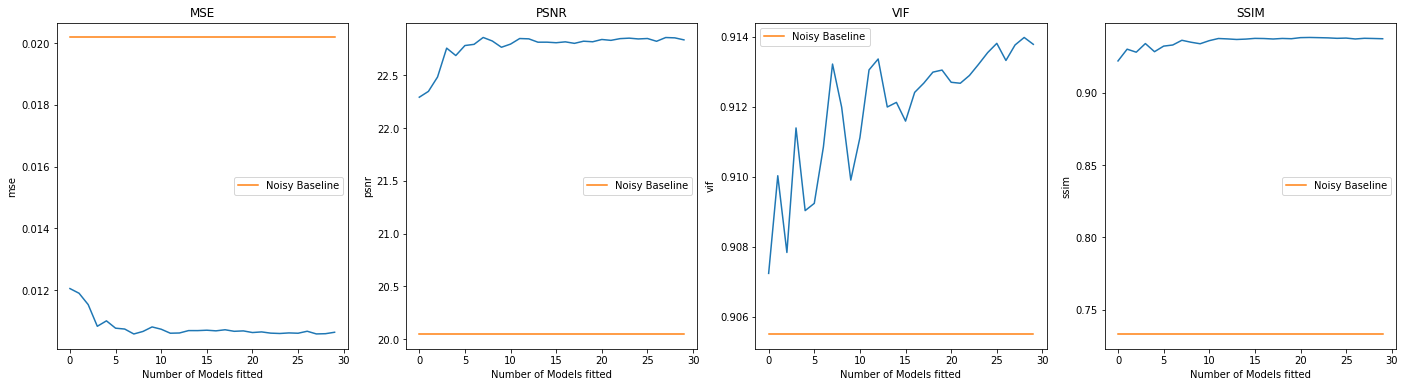

In [17]:
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))
for axis, measure in zip(axes, measures):
    x_vec, y_vec = generate_plot_vectors(performances, measure, 'number of models')
    axis.plot(x_vec, y_vec)
    axis.plot(x_vec, [noisy_baseline[measure]]*len(y_vec), label='Noisy Baseline')
    axis.set_xlabel('Number of Models fitted')
    axis.set_ylabel(measure)
    axis.legend()
    axis.set_title(measure.upper())

# Display Images

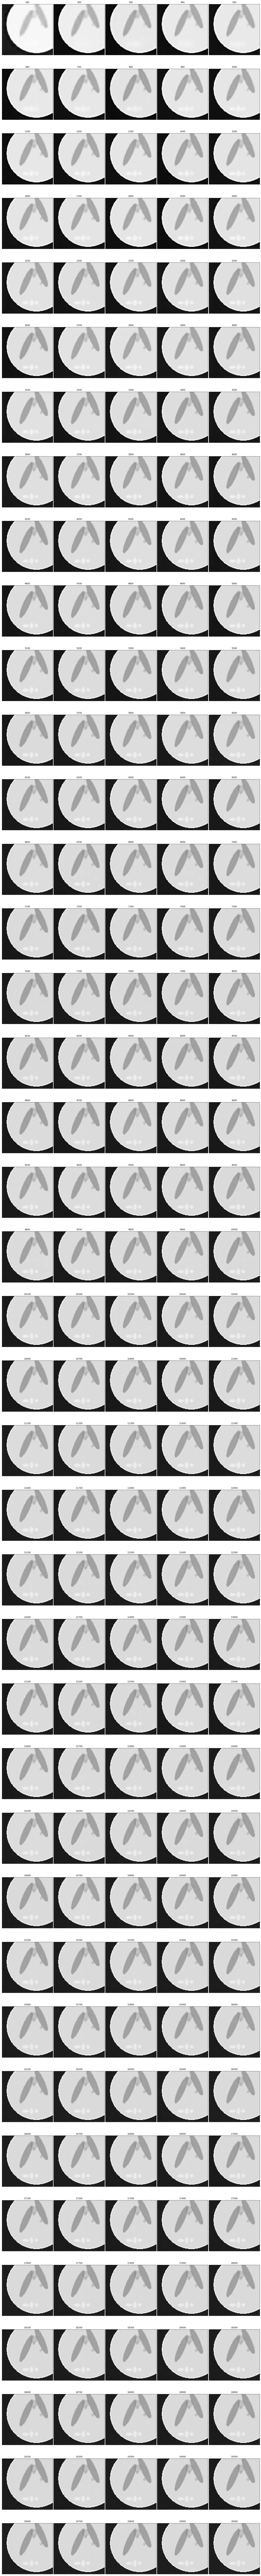

In [18]:
images_to_display = [median_images(x) for x in model_step_images]
titles = [x * size_of_interval for x in list(range(1, number_of_intervals + 1))]
plot_image_grid(images_to_display, titles, ncols=5)
plt.show()